In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import blackjax

In [2]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, infos = kernel(rng_key, state)
        return state, (state, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

In [3]:
d = 1


def logprob(x):
    return -0.5 * jnp.dot(x, x)


logprob_fn = lambda params: logprob(**params)

# Random walk metropolis hastings

In [4]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d) / 1)

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {"momentum": initial_position}  # initial value doesn't matter
aux_logprob_fn = lambda state: -kinetic_energy(state.momentum)
aux_generator = lambda rng_key, state: {
    "momentum": momentum_generator(rng_key, state.position)
}

In [5]:
def rwmh_involution(state):
    return (
        state._replace(
            position=state.momentum,
            potential_energy=-logprob_fn(state.momentum),
            momentum=state.position,
        ),
        0.0,
    )


involutions = [rwmh_involution]

In [6]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [7]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", infos[0].p_accept.mean())

Acceptance probability: 1.0


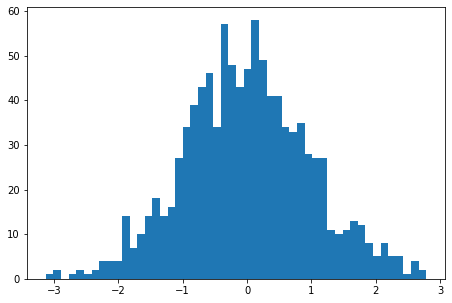

In [8]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

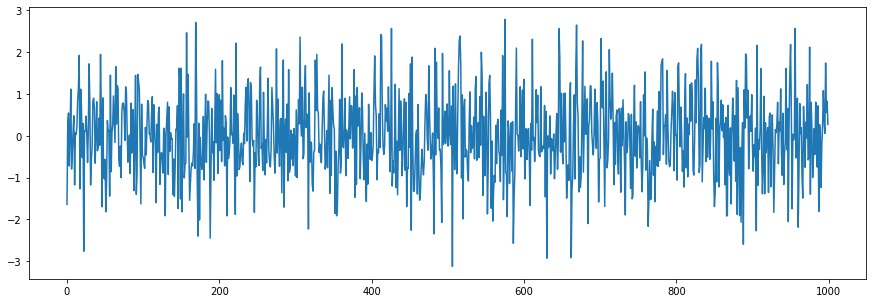

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Vanilla HMC 0

Momentum needs symmetric density.

In [10]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d))

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {"momentum": initial_position}
aux_logprob_fn = lambda state: -kinetic_energy(state.momentum)
aux_generator = lambda rng_key, state: {
    "momentum": momentum_generator(rng_key, state.position)
}

In [11]:
from jax.tree_util import tree_map

from blackjax.mcmc.integrators import velocity_verlet

int_step = velocity_verlet(lambda x: -logprob_fn(x), kinetic_energy)


def hmc_involution(state, L, step_size):
    int_state = state.to_integrator()

    def step(int_state, _):
        int_state = int_step(int_state, step_size)
        return int_state, int_state

    int_state, _ = jax.lax.scan(step, int_state, None, length=L)
    new_state = state.from_integrator(int_state)
    return new_state.flip_momentum(), 0.0


#     int_state = int_state._replace(momentum=tree_map(lambda x: -x, int_state.momentum))
#     return state._replace(
#         **int_state._asdict()
#     ), 0.

involutions = [lambda state: hmc_involution(state, 1, 2.0)]

In [12]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [13]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", infos[0].p_accept.mean())

Acceptance probability: 0.52698123


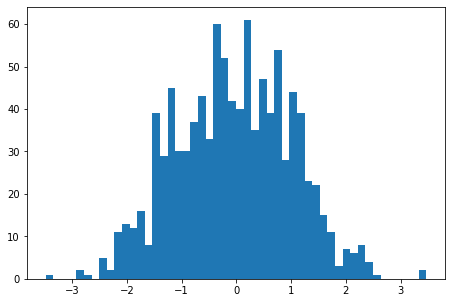

In [14]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

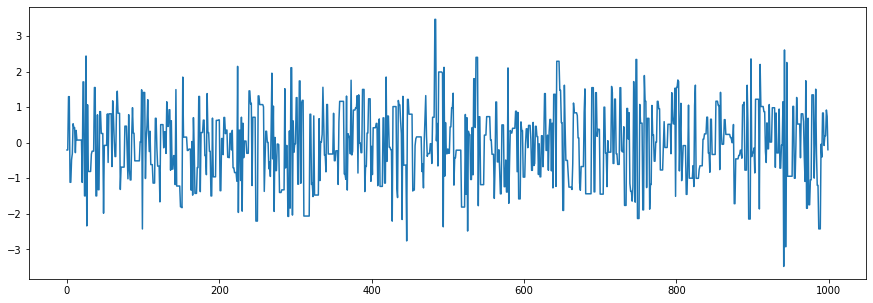

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Vanilla HMC 1

In [30]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d))

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {
    #     'momentum': momentum_generator(jax.random.PRNGKey(1), initial_position),
    "momentum": initial_position,
    "d": +1,
}
aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - jnp.log(2)
aux_generator = lambda rng_key, state: {
    "momentum": momentum_generator(rng_key, state.position),
    "d": state.d,
}

In [31]:
from blackjax.mcmc.integrators import velocity_verlet

int_step = velocity_verlet(lambda x: -logprob_fn(x), kinetic_energy)


def hmc_involution(state, L, step_size):
    int_state = state.flip_momentum().to_integrator()

    def step(int_state, _):
        int_state = int_step(int_state, step_size)
        return int_state, int_state

    int_state, _ = jax.lax.scan(step, int_state, None, length=L)
    new_state = state.from_integrator(int_state).flip_momentum()
    return new_state._replace(d=-new_state.d), 0.0


involutions = [lambda state: hmc_involution(state, 1, 2.0)]

In [32]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [33]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", infos[0].p_accept.mean())

Acceptance probability: 0.51358294


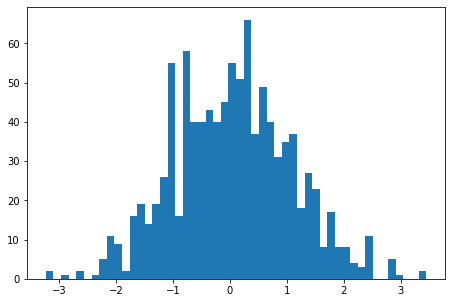

In [34]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

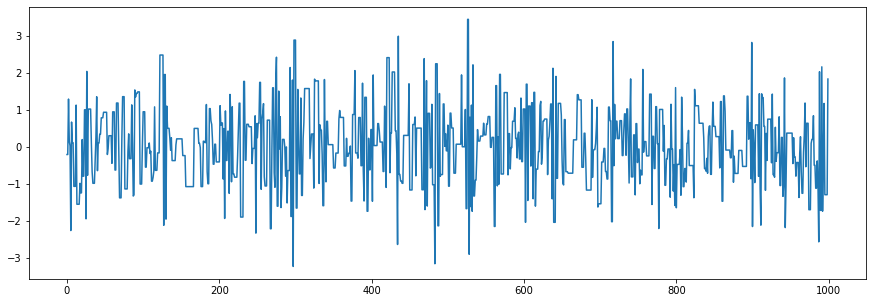

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Vanilla HMC 2

In [36]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d))

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {
    #     'momentum': momentum_generator(jax.random.PRNGKey(1), initial_position),
    "momentum": initial_position,
    "d": +1,
}
aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - jnp.log(2)
aux_generator = lambda rng_key, state: {
    "momentum": momentum_generator(rng_key, state.position),
    "d": state.d,
}

In [37]:
from blackjax.mcmc.integrators import velocity_verlet

int_step = velocity_verlet(lambda x: -logprob_fn(x), kinetic_energy)


def hmc_involution(state, L, step_size):
    int_state = state.to_integrator()

    def step(int_state, _):
        int_state = int_step(int_state, state.d * step_size)
        return int_state, int_state

    int_state, _ = jax.lax.scan(step, int_state, None, length=L)

    new_state = state.from_integrator(int_state)
    return new_state._replace(d=-new_state.d), 0.0


involutions = [lambda state: hmc_involution(state, 1, 2.0)]

In [38]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [42]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", infos[0].p_accept.mean())

Acceptance probability: 0.51358294


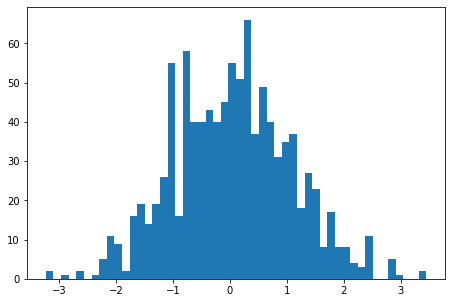

In [43]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

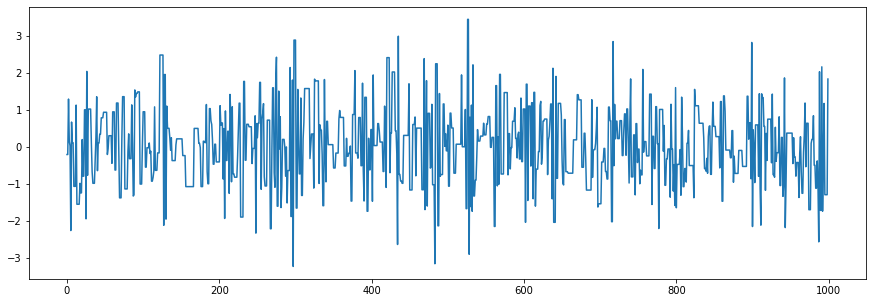

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Irreversible Vanilla HMC

In [45]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d))

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {
    #     'momentum': momentum_generator(jax.random.PRNGKey(1), initial_position),
    "momentum": initial_position,
    "d": +1,
}
aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - jnp.log(2)
aux_generator = lambda rng_key, state: {
    "momentum": momentum_generator(rng_key, state.position),
    "d": state.d,
}

In [46]:
from blackjax.mcmc.integrators import velocity_verlet

int_step = velocity_verlet(lambda x: -logprob_fn(x), kinetic_energy)


def hmc_involution(state, L, step_size):
    int_state = state.to_integrator()

    def step(int_state, _):
        int_state = int_step(int_state, state.d * step_size)
        return int_state, int_state

    int_state, _ = jax.lax.scan(step, int_state, None, length=L)

    new_state = state.from_integrator(int_state)
    return new_state._replace(d=-new_state.d), 0.0


def flip_involution(state):
    return state._replace(d=-state.d), 0.0


involutions = [lambda state: hmc_involution(state, 1, 2.0), flip_involution]

In [47]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [48]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", [info.p_accept.mean() for info in infos])

Acceptance probability: [DeviceArray(0.520881, dtype=float32), DeviceArray(1., dtype=float32)]


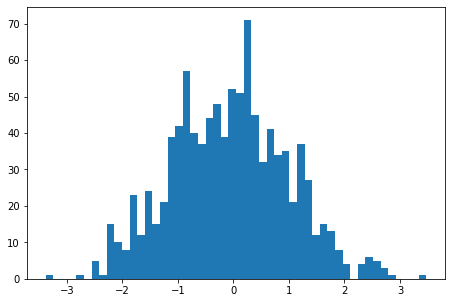

In [49]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

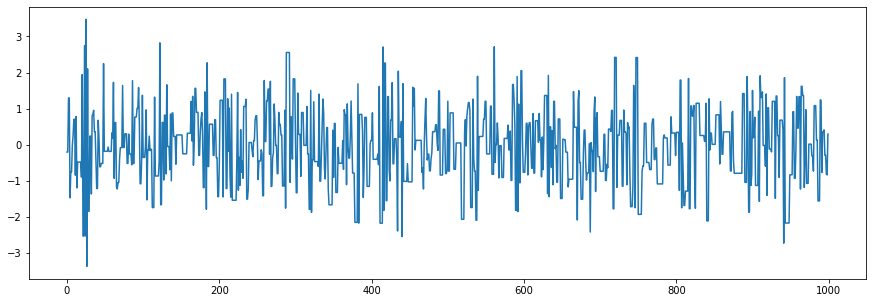

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Elliptical Slice Sampler

In [166]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d) / 0.1)

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {"momentum": initial_position, "d": 0.0, "theta": 0.0, "a": 1}


def y_density(position, momentum):
    return (
        logprob_fn(position)
        #         + kinetic_energy(position)
        - kinetic_energy(momentum)
    )


aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - y_density(
    state.position, state.momentum
)

In [167]:
from jax.lax import while_loop
from jax.tree_util import tree_multimap


def ellipsis(x, v, theta):
    x_ = tree_multimap(lambda x, v: x * jnp.cos(theta) + v * jnp.sin(theta), x, v)
    v_ = tree_multimap(lambda x, v: v * jnp.cos(theta) - x * jnp.sin(theta), x, v)
    return x_, v_


def aux_generator(rng_key, state):
    key_momentum, key_d, key_theta = jax.random.split(rng_key, 3)
    # step 1
    momentum = momentum_generator(key_momentum, state.position)
    # step 2 & 3: get slice (y)
    u = jax.random.uniform(key_d)
    d = y_density(state.position, momentum) + jnp.log(u)
    # step 4 & 5: get theta
    theta = 2 * jnp.pi * jax.random.uniform(key_theta)
    theta_min = theta - 2 * jnp.pi
    theta_max = theta
    # step 6: proposal
    x, v = ellipsis(state.position, momentum, theta)
    # step 7-16:
    logprob = y_density(x, v)

    def while_fun(vals):
        rng, _, subiter, theta, theta_min, theta_max, *_ = vals
        rng, key_theta = jax.random.split(rng)
        theta = jax.random.uniform(key_theta, minval=theta_min, maxval=theta_max)
        x, v = ellipsis(state.position, momentum, theta)
        logprob = y_density(x, v)
        theta_min = jnp.where(theta < 0, theta, theta_min)
        theta_max = jnp.where(theta > 0, theta, theta_max)
        subiter += 1
        return rng, logprob, subiter, theta, theta_min, theta_max, x, v

    *_, subiter, theta, _, _, x, v = while_loop(
        lambda vals: vals[1] < d,
        while_fun,
        (key_theta, logprob, 1, theta, theta_min, theta_max, x, v),
    )
    return {"momentum": momentum, "d": d, "theta": theta, "a": subiter}


def ess_involution(state):
    position, momentum = ellipsis(state.position, state.momentum, state.theta)
    return (
        state._replace(
            position=position,
            potential_energy=-logprob_fn(position),
            momentum=momentum,
            theta=-state.theta,
        ),
        0.0,
    )


involutions = [ess_involution]

In [168]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [169]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", [info.p_accept.mean() for info in infos])
print("Subiter (mean/std):", states.a.mean(), states.a.std())

Acceptance probability: [DeviceArray(1., dtype=float32)]
Subiter (mean/std): 1.983 1.8272141


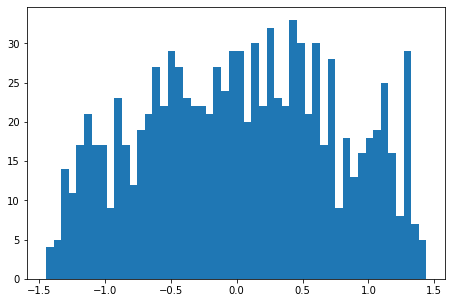

In [170]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

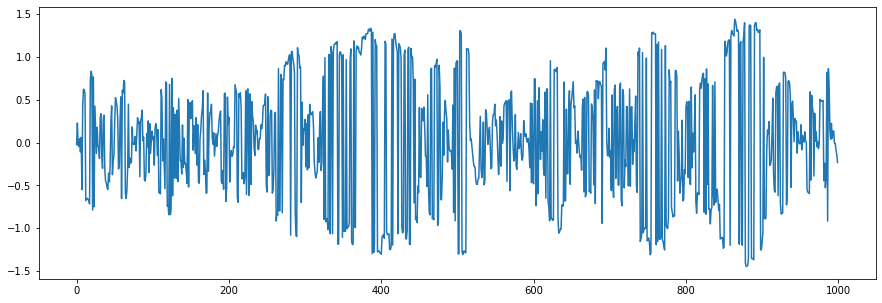

In [171]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Simple Elliptical slice sampler

In [145]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d) / 100)

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {
    "momentum": initial_position,
    "theta": 0.0,
}

aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - jnp.log(2 * jnp.pi)

In [146]:
from jax.tree_util import tree_multimap


def ellipsis(x, v, theta):
    x_ = tree_multimap(lambda x, v: x * jnp.cos(theta) + v * jnp.sin(theta), x, v)
    v_ = tree_multimap(lambda x, v: v * jnp.cos(theta) - x * jnp.sin(theta), x, v)
    return x_, v_


def aux_generator(rng_key, state):
    key_momentum, key_theta = jax.random.split(rng_key)
    # step 1
    momentum = momentum_generator(key_momentum, state.position)
    # step 4 & 5: get theta
    theta = 2 * jnp.pi * jax.random.uniform(key_theta)
    return {
        "momentum": momentum,
        "theta": theta,
    }


def ess_involution(state):
    position, momentum = ellipsis(state.position, state.momentum, state.theta)
    return (
        state._replace(
            position=position,
            potential_energy=-logprob_fn(position),
            momentum=momentum,
            theta=-state.theta,
        ),
        0.0,
    )


involutions = [ess_involution]

In [147]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [148]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", [info.p_accept.mean() for info in infos])

Acceptance probability: [DeviceArray(0.2589235, dtype=float32)]


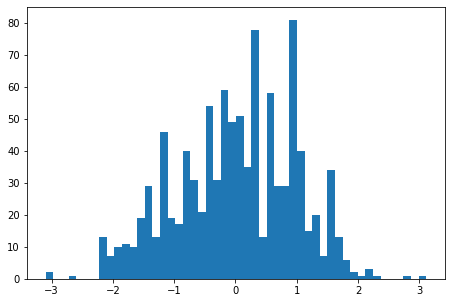

In [149]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

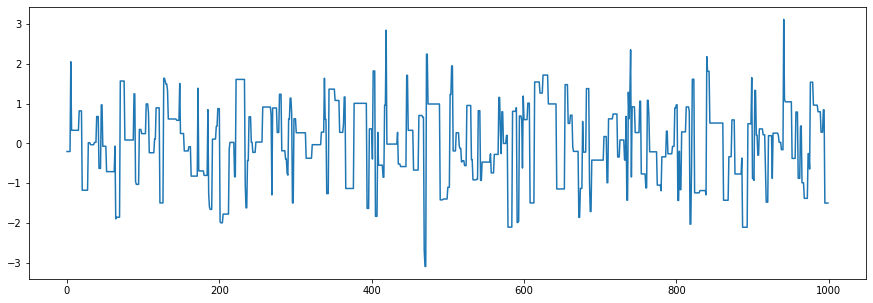

In [150]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()

# Irreversible simple elliptical slice sampler

In [139]:
from blackjax.mcmc.metrics import gaussian_euclidean

momentum_generator, kinetic_energy, _ = gaussian_euclidean(jnp.ones(d) / 100)

initial_position = {"x": jax.random.normal(jax.random.PRNGKey(0), (d,))}
initial_auxiliary = {
    "momentum": initial_position,
    "theta": 0.0,
    "d": +1,
}

aux_logprob_fn = lambda state: -kinetic_energy(state.momentum) - jnp.log(2 * jnp.pi)

In [140]:
from jax.tree_util import tree_multimap


def ellipsis(x, v, theta):
    x_ = tree_multimap(lambda x, v: x * jnp.cos(theta) + v * jnp.sin(theta), x, v)
    v_ = tree_multimap(lambda x, v: v * jnp.cos(theta) - x * jnp.sin(theta), x, v)
    return x_, v_


def aux_generator(rng_key, state):
    key_momentum, key_theta = jax.random.split(rng_key)
    # step 1
    momentum = momentum_generator(key_momentum, state.position)
    # step 4 & 5: get theta
    theta = jnp.pi * jax.random.uniform(key_theta)
    return {
        "momentum": momentum,
        "theta": theta,
    }


def ess_involution(state):
    position, momentum = ellipsis(state.position, state.momentum, state.d * state.theta)
    return (
        state._replace(
            position=position,
            potential_energy=-logprob_fn(position),
            momentum=momentum,
            d=-state.d,
        ),
        0.0,
    )


def flip_involution(state):
    return state._replace(d=-state.d), 0.0


involutions = [ess_involution, flip_involution]

In [141]:
imcmc = blackjax.imcmc(logprob_fn, aux_logprob_fn, aux_generator, involutions)
initial_state = imcmc.init(initial_position, initial_auxiliary)
kernel = jax.jit(imcmc.step)

In [142]:
rng_key = jax.random.PRNGKey(0)
states, infos = inference_loop(rng_key, kernel, initial_state, 1000)
print("Acceptance probability:", [info.p_accept.mean() for info in infos])

Acceptance probability: [DeviceArray(0.2775669, dtype=float32), DeviceArray(1., dtype=float32)]


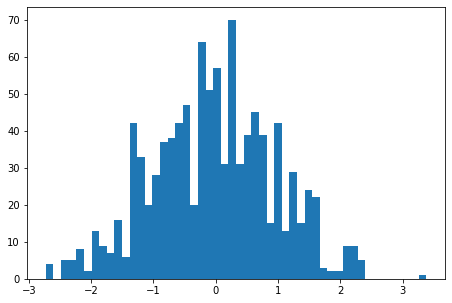

In [143]:
plt.figure(figsize=(7.5, 5))
plt.hist(np.array(states.position["x"]), bins=50)
plt.show()

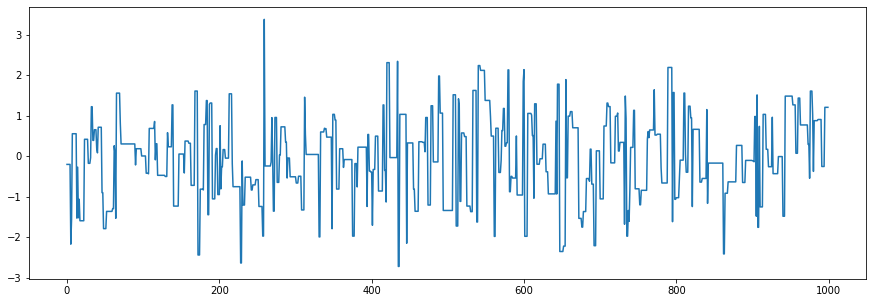

In [144]:
plt.figure(figsize=(15, 5))
plt.plot(states.position["x"])
plt.show()